# Exercise 5 - BLOB Analysis (connected component analysis and object classification)

The purpose of this exercise is to implement, test and validate connected component analysis methods. Also known as BLOB (binary large object) analysis.

The methods will be used to create a small program that can count cell nucle.

## BLOB Analysis in Python 
Start by importing some function:

In [37]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

and define a convenience function to show two images side by side:

In [38]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### LEGO Classification

We will start by trying some BLOB analysis approaches on a photo of some Lego bricks: _lego_4_small.png_

#### Exercise 1: Binary image from original image

Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

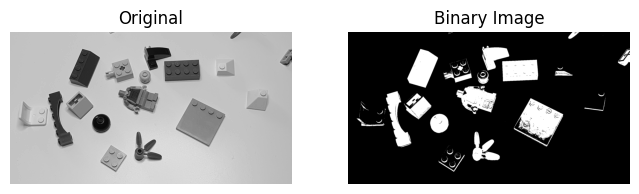

In [39]:
in_dir = "data/"
im_name = "lego_4_small.png"

img = io.imread(in_dir+im_name)

gray_img = color.rgb2gray(img)
thresh = threshold_otsu(gray_img)
bin_img = gray_img <=thresh

show_comparison(gray_img,bin_img, "Binary Image")

#### Exercise 2: Remove border BLOBs

Use segmentation.clear_border to remove border pixels from the binary image

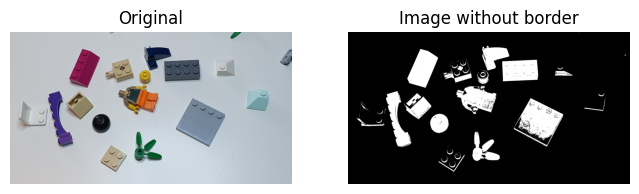

In [40]:
cleared = segmentation.clear_border(bin_img)
show_comparison(img, cleared, 'Image without border')

#### Exercise 3: Cleaning using morphological operations

In order to remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5. See Exercise 4b if you are in doubt.

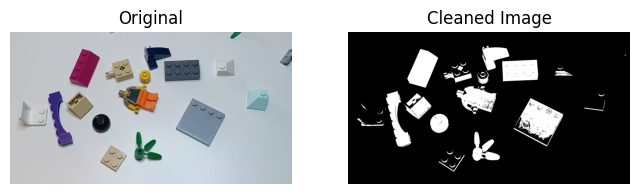

In [41]:
opened = morphology.opening(cleared, morphology.disk(1))
#closed = morphology.closing(opened, morphology.disk(10))
show_comparison(img, opened, 'Cleaned Image')

#### Exercise 4: Find labels

THe actual connected component analysis/ BLOB analaysis is perfromed using measure.label :

In [42]:
label_img = measure.label(opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 90


#### Exercice 5: Visualize found labels
We can use the function label2rgb to create a visualization of the found BLOBS. Show this together with the original image.

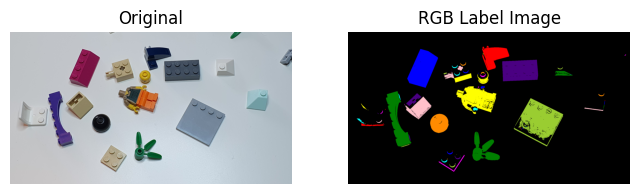

In [43]:
rgb_label_img = label2rgb(label_img)
show_comparison(img, rgb_label_img, "RGB Label Image")

#### Exercise 7: Exploring BLOB features
There is an example program called Ex5-BlobAnalysisInteractive.py in the exercise material folder. 

With that program, you can explore different BLOB features interactively. It requieres installation of plotly.

### Cell counting

The goal of this part of the exercise, is to create a small program that can automatically count the number of cell nuclei in an image.

The images used for the exercise is acquired by the Danish company Chemometec using their image-based cytomers. A cytometer is a machine used in many laboratories to do atomated cell counting and analysis. An example image can be seen in below where U2OS cells (human bone cells) have been imaged using ultraviolet (UV) microscopy and a flourescent staining method named DAPI. Using DAPI staining only the cell nuclei are visible which makes the method very suitable for cell counting.

The raw images from the Cytometer are 1920x1440 pixels and each pixel is 16 bit (values from 0 to 65535). The resolution is 1.1 micrometers/pixel.

To make it easier to develop the cell counting program we start by working with smaller areas of the raw images. The images are also converted to 8 bit grayscale images:

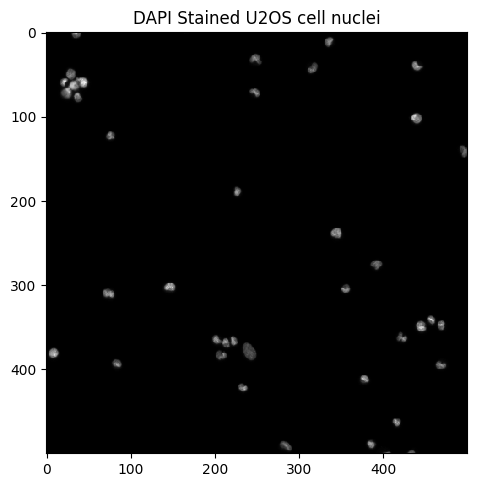

In [44]:
in_dir = "data/"
img_org = io.imread(in_dir + "Sample E2 - U2OS DAPI channel.tiff")
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small)
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

As can be seen we use slicing to extract a part of the image. You can use vmin and vmax to visualise specific gray scale ranges (0 to 150 in the example above). Adjust these limits to find out where the cell nuclei are most visible.

Initially, we would like to apply a threshold to create a binary image where nuclei are foreground. To select a good threshold, inspect the histogram:

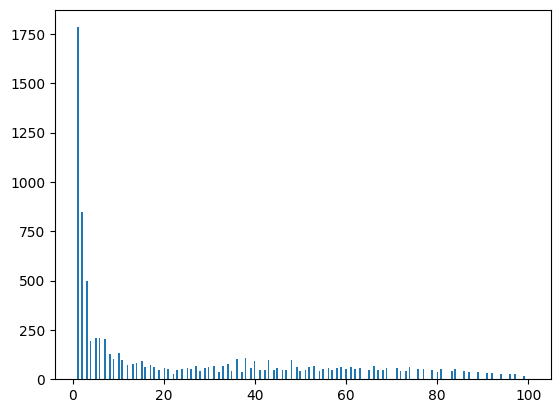

In [45]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1,100))
io.show()

#### Exercise 8: Threshold selection

Select an appropiate threshold, that separates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

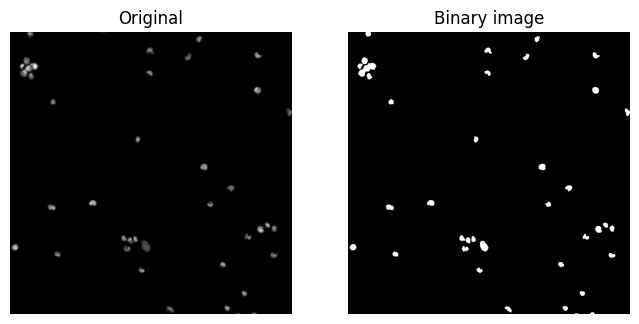

In [46]:
thresh = threshold_otsu(img_gray)
bin_img = img_gray >= thresh
show_comparison(img_gray, bin_img, "Binary image")

It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separete them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.

#### Exercise 9: Remove border BLOBS
Use segmentation.clear_border to remove border pixels from the binary image.

To be able to analyse the individual objects, the objects should be labelled.

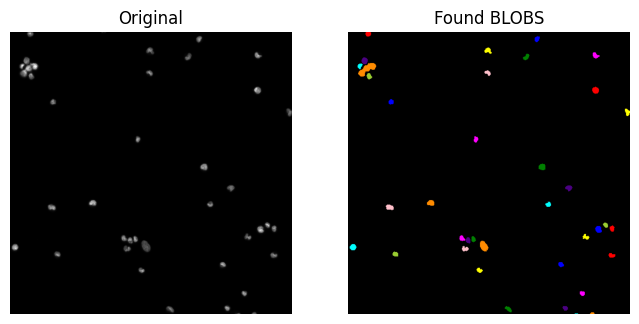

In [47]:
label_img = measure.label(bin_img)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

In this image, each object has a separate color - does it look reasonable?

#### Exercise 10: BLOB features

The task is now to find some object features that identify the cell nuclei and let us remove noise and connected nuclei. We use the function regionprops to compute a set of features for each object:

In [48]:
region_props = measure.regionprops(label_img)

For example can the area of the first object be seen by:
print(region_props[0].area).

A quick way to gather all areas:

In [49]:
areas = np.array([prop.area for prop in region_props])
print(areas)

[ 69  72  92  85  81 105 365  61  68  76 116  69  81  66 116  93 107  67
 107  61  71 113  74  74  64  71 199 103  80  72  74  70  67  63  79  62
  20   6]


We can try if the area of the objects is enough to remove invalid object. Plot a histogram of all the areas and see if it can be used to identify well separated nuclei from overlapping nuclei and noise. You should probably play around with the number of bins in your histogram plotting function.

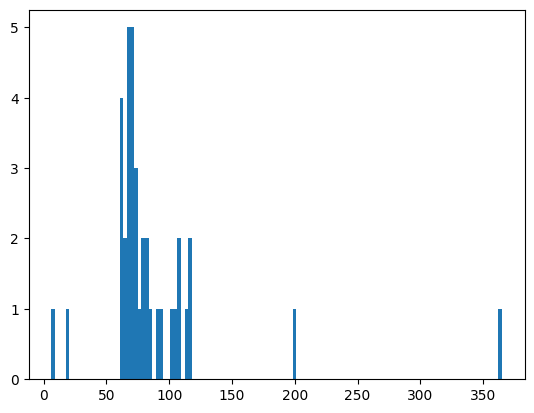

In [77]:
plt.hist(areas, bins=125)
io.show()

#### Exercise 11: BLOB classification by area

Select a minimum and maximum allowd area and use the following to visualize the result:

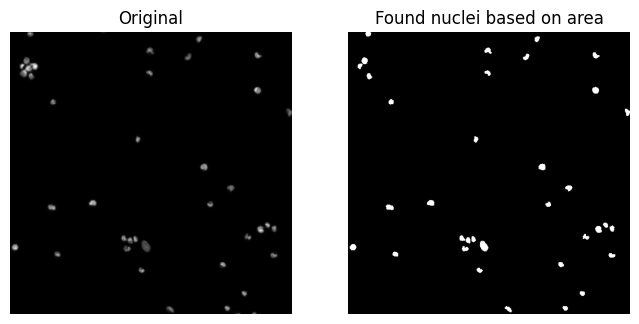

In [74]:
min_area = 50
max_area = 200

img_gray = img_as_ubyte(img_small)
thresh = threshold_otsu(img_gray)
bin_img = img_gray >= thresh
label_img = measure.label(bin_img)
image_label_overlay = label2rgb(label_img)

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find areas that can do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

Can you find an area interval that works well fro these nuclei?

#### Exercise 12: Feature space

Extract all the perimeters of the BLOBS:

In [79]:
perimeters = np.array([prop.perimeter for prop in region_props])
print(perimeters)

[28.48528137 30.14213562 39.79898987 35.55634919 35.79898987 35.55634919
 93.254834   28.14213562 31.55634919 30.97056275 38.38477631 28.72792206
 34.14213562 29.3137085  38.72792206 35.79898987 36.72792206 30.72792206
 38.72792206 26.72792206 30.14213562 37.55634919 37.21320344 32.97056275
 28.14213562 29.3137085  55.69848481 34.97056275 37.21320344 29.89949494
 32.48528137 28.72792206 30.38477631 27.3137085  35.79898987 27.3137085
 16.24264069  4.        ]


Try to plot the areas versus the perimeters.

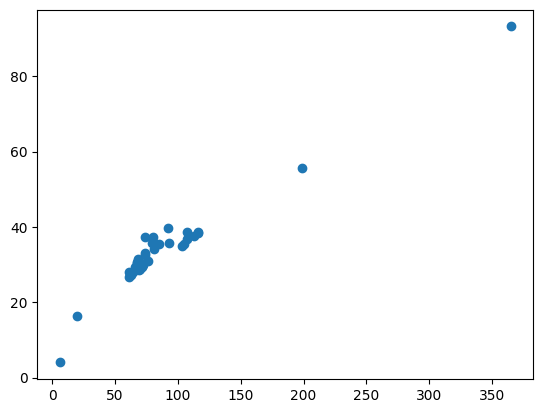

In [80]:
plt.scatter(areas, perimeters)
plt.show()

#### Exercise 13: BLOB Circularity

We should also examine if the shape of the cells can identify them. A good meaure of how circular an object is can be computed as: 

$f_{circ} = \dfrac{4\cdot \pi \cdot A}{P^{2}}$

where A is the object area and P is the perimeter. A circle has a circularity close to 1, and very-non-circular object have circularity close to 0.

Compute the circularity for all objects and plot a histogram.

Selecto some appropiate ranges of accepted circularity. Use these ranges to select only the cells with acceptable areas and circularity and show them in an image.

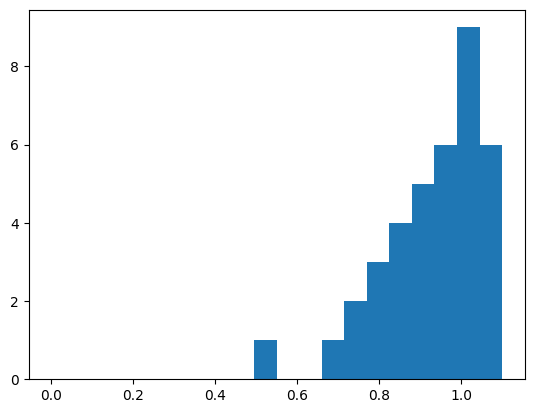

In [87]:
circularity = np.divide(4*np.pi*areas, np.power(perimeters,2))
plt.hist(circularity, bins=20, range = (0, 1.1))
io.show()

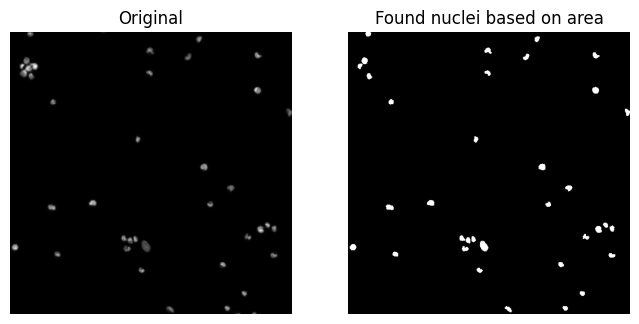

In [100]:
min_area = 50
max_area = 200
min_circularity = 0.5
max_circularity = 1.3

img_gray = img_as_ubyte(img_small)
thresh = threshold_otsu(img_gray)
bin_img = img_gray >= thresh
label_img = measure.label(bin_img)
image_label_overlay = label2rgb(label_img)

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])
circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
counting  = len(circularities)
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Cacule the circularity of nuclei
    circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))
    # Find areas that can do not fit our criteria
    if (region.area > max_area or region.area < min_area) or (circularity > max_circularity or circularity < min_circularity):
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
        counting = counting - 1
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

#### Exercise 14: BLOB circularity and area

Try to plot the areas versus the circularity. What do you observe?

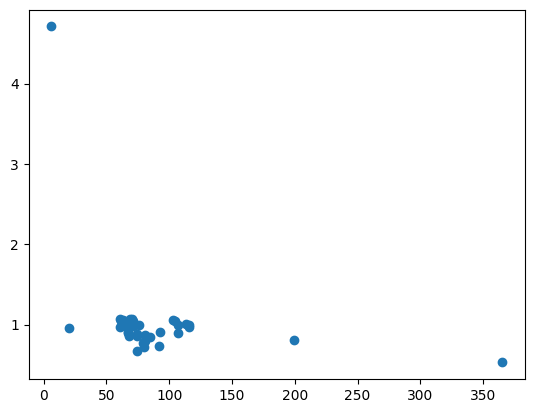

In [93]:
plt.scatter(areas, circularities)

Extend your method to return the number (the count) of well-formed nuclei in the image.

In [99]:
print(counting)

35


#### Exercise 15: large scale testing
Try to test the method on a larger set of training images. Use sliceng to select the different regions from the raw image.

C:\Users\Admin\AppData\Local\Temp\ipykernel_7700\680779020.py:16: RuntimeWarning: divide by zero encountered in divide
  circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
C:\Users\Admin\AppData\Local\Temp\ipykernel_7700\680779020.py:23: RuntimeWarning: divide by zero encountered in divide
  circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))


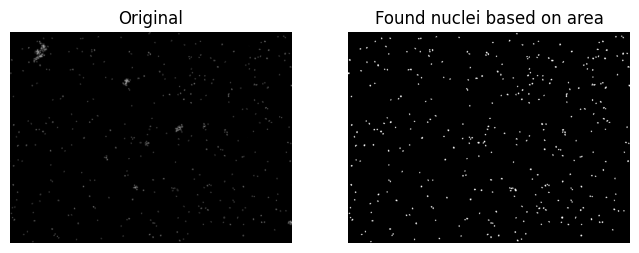

Initial nuclei: 382; Final nuclei: 361


In [105]:
img_gray = img_as_ubyte(img_org)
thres = threshold_otsu(img_gray)
bin_img = img_gray >=thresh

min_area = 50
max_area = 200
min_circularity = 0.5
max_circularity = 1.3

label_img = measure.label(bin_img)
image_label_overlay = label2rgb(label_img)

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])
circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
counting_initial  = len(circularities)
counting_final = counting_initial
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Cacule the circularity of nuclei
    circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))
    # Find areas that can do not fit our criteria
    if (region.area > max_area or region.area < min_area) or (circularity > max_circularity or circularity < min_circularity):
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
        counting_final = counting_final - 1
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_org, i_area, 'Found nuclei based on area')
print(f"Initial nuclei: {counting_initial}; Final nuclei: {counting_final}")


#### Exercise 16: COS7 cell classification

Try your method on the _Sample G1 - COS7 cells DAPI channel.tiff_ image. COS7 cells are African Green Monkey Fibroblas-like Kidney Cells used for a variety of research purposes.

C:\Users\Admin\AppData\Local\Temp\ipykernel_7700\918795079.py:19: RuntimeWarning: divide by zero encountered in divide
  circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
C:\Users\Admin\AppData\Local\Temp\ipykernel_7700\918795079.py:26: RuntimeWarning: divide by zero encountered in divide
  circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))


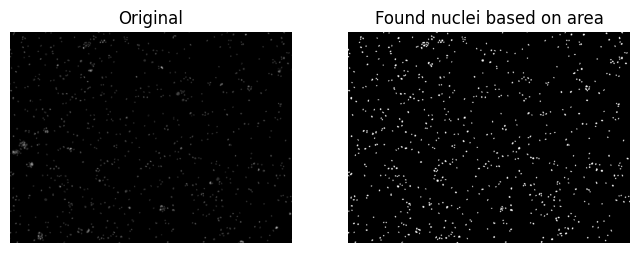

Initial nuclei: 808; Final nuclei: 710


In [124]:
im_name = "Sample G1 - COS7 cells DAPI channel.tiff"
img_org = io.imread(in_dir+im_name)

img_gray = img_as_ubyte(img_org)
thres = threshold_otsu(img_gray)
bin_img = img_gray >=thresh

min_area = 50
max_area = 200
min_circularity = 0.5
max_circularity = 1.3

label_img = measure.label(bin_img)
image_label_overlay = label2rgb(label_img)

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])
circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
counting_initial  = len(circularities)
counting_final = counting_initial
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Cacule the circularity of nuclei
    circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))
    # Find areas that can do not fit our criteria
    if (region.area > max_area or region.area < min_area) or (circularity > max_circularity or circularity < min_circularity):
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
        counting_final = counting_final - 1
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_org, i_area, 'Found nuclei based on area')
print(f"Initial nuclei: {counting_initial}; Final nuclei: {counting_final}")


#### Exercise 17: Handling overlap

In certain cases cell nuclei are touching and are therefore being treated as one object. It can sometimes be solved using for example the morphological operation opening before the object labelling. The operation erosion can also be used but it changes the object area.

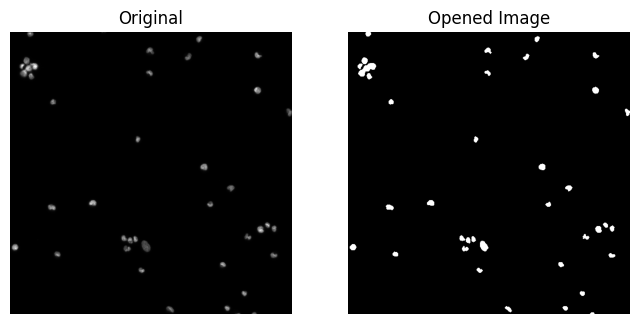

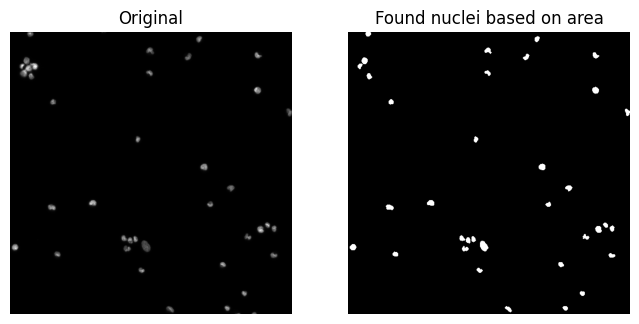

Initial nuclei: 382; Final nuclei: 361


In [123]:
min_area = 50
max_area = 200
min_circularity = 0.5
max_circularity = 1.3

img_gray = img_as_ubyte(img_small)
thresh = threshold_otsu(img_gray)
bin_img = img_gray >= thresh

opened = morphology.opening(bin_img, morphology.disk(1))
show_comparison(img_small, opened, "Opened Image")

label_img = measure.label(opened)
image_label_overlay = label2rgb(label_img)

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])
circularities = np.divide(4*np.pi*areas, np.power(perimeters,2))
counting  = len(circularities)
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Cacule the circularity of nuclei
    circularity = np.divide(4*np.pi*region.area, np.power(region.perimeter,2))
    # Find areas that can do not fit our criteria
    if (region.area > max_area or region.area < min_area) or (circularity > max_circularity or circularity < min_circularity):
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
        counting = counting - 1
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')
print(f"Initial nuclei: {counting_initial}; Final nuclei: {counting_final}")